In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import wfdb
import statsmodels.api as sm
import matplotlib.image as mpimg
import tkinter as tk
from matplotlib.figure import Figure
from IPython.display import display, HTML
import csv
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import pickle
from sklearn.linear_model import LogisticRegression
import tensorflow.keras as ks
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as Ks
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from numpy.random import seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# 1510 Records
# 752 Records True 0 - 751
# 758 Records False 752 - 1509

In [3]:
f = r'RRFrame.csv'
rrFrame = pd.read_csv(f, encoding='iso-8859-1')
f = r'SpO2Frame.csv'
spFrame = pd.read_csv(f, encoding='iso-8859-1')
f = r'LabelFrame.csv'
labelFrame = pd.read_csv(f, encoding='iso-8859-1')
print(np.shape(rrFrame))


RECORDS = np.shape(rrFrame)[0]
TOTAL_POINTS = np.shape(rrFrame)[1] - 1
INPUT = np.zeros((RECORDS,TOTAL_POINTS,2), dtype=np.float64)
OUTPUT = np.zeros((RECORDS),dtype=np.float64)

for i in range(RECORDS):
    INPUT[i,:,0] = rrFrame.iloc[i][1:1441]
    if(np.isnan(INPUT[i,:,0]).any()):
        print('rr '+ str(i))
    INPUT[i,:,1] = spFrame.iloc[i][1:1441]
    if(np.isnan(INPUT[i,:,1]).any()):
            print('sp '+ str(i))
    if(int(labelFrame.iloc[i]) == 0):
        OUTPUT[i] = 0
    if(int(labelFrame.iloc[i]) == 1):
        OUTPUT[i] = 1

print(np.shape(INPUT))
print(np.shape(OUTPUT))
# SHIFTING INPUT OF RR AND SPO2 BY SUITABLE VALUES
INPUT[:,:,0] = (INPUT[:,:,0] - 25)/10
INPUT[:,:,1] = (INPUT[:,:,1] - 93)/10
#print(INPUT)
print(np.isnan(INPUT).any())
print(np.isnan(OUTPUT).any())

(1510, 1441)
(1510, 1440, 2)
(1510,)
False
False


In [4]:
# Take 400 of both cases for training
# Take 100 of both cases for validation
# Take remaining of both cases for testing
TN = 400
VN = 100
E1 = 752
E2 = 1510


X_TRAIN = INPUT[0:TN,:,:]
X_TRAIN = np.concatenate((X_TRAIN,INPUT[E1:E1+TN,:,:]),axis=0)
Y_TRAIN = OUTPUT[0:TN]
Y_TRAIN = np.concatenate((Y_TRAIN,OUTPUT[E1:E1+TN]),axis=0)

X_VALIDATE = INPUT[TN:TN+VN,:,:]
X_VALIDATE = np.concatenate((X_VALIDATE,INPUT[E1+TN:E1+TN+VN,:,:]),axis=0)
Y_VALIDATE = OUTPUT[TN:TN+VN]
Y_VALIDATE = np.concatenate((Y_VALIDATE,OUTPUT[E1+TN:E1+TN+VN]),axis=0)

X_TEST = INPUT[TN+VN:E1,:,:]
X_TEST = np.concatenate((X_TEST,INPUT[E1+TN+VN:E2,:,:]),axis=0)
Y_TEST = OUTPUT[TN+VN:E1]
Y_TEST = np.concatenate((Y_TEST,OUTPUT[E1+TN+VN:E2]),axis=0)

print(np.shape(X_TRAIN))
print(np.shape(Y_TRAIN))
print(np.shape(X_VALIDATE))
print(np.shape(Y_VALIDATE))
print(np.shape(X_TEST))
print(np.shape(Y_TEST))

(800, 1440, 2)
(800,)
(200, 1440, 2)
(200,)
(510, 1440, 2)
(510,)


In [5]:
# design network
seed(7)
model = Sequential()
model.add(LSTM(30, input_shape=(X_TRAIN.shape[1], X_TRAIN.shape[2]),return_sequences=False))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc','mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3960      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# fit network
EPOCHS = 250
BATCH_SIZE = 200
model_checkpoint = ModelCheckpoint('QuantLSTM.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
csv_logger = CSVLogger('QuantLSTM.log')
model.fit(X_TRAIN, Y_TRAIN, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_VALIDATE, Y_VALIDATE), verbose=1, shuffle=False,callbacks=[csv_logger,model_checkpoint])
print('Score on validation set')
score = model.evaluate(X_VALIDATE, Y_VALIDATE, batch_size=BATCH_SIZE)
print(score)
print('Score on test set')
score = model.evaluate(X_TEST,Y_TEST, batch_size=BATCH_SIZE)
print(score)

Train on 800 samples, validate on 200 samples
Epoch 1/250
600/800 [=====================>........] - ETA: 0s - loss: 6.6432 - acc: 0.3333 - mse: 0.6771    
Epoch 00001: val_loss improved from inf to 3.79739, saving model to QuantLSTM.h5
800/800 [==============================] - 3s 4ms/sample - loss: 5.0032 - acc: 0.5000 - mse: 0.5100 - val_loss: 3.7974 - val_acc: 0.5000 - val_mse: 0.4703
Epoch 2/250
400/800 [==============>...............] - ETA: 0s - loss: 7.1661 - acc: 0.0000e+00 - mse: 0.9108
Epoch 00002: val_loss improved from 3.79739 to 3.31604, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 428us/sample - loss: 3.6532 - acc: 0.5000 - mse: 0.4656 - val_loss: 3.3160 - val_acc: 0.5000 - val_mse: 0.4494
Epoch 3/250
400/800 [==============>...............] - ETA: 0s - loss: 5.3697 - acc: 0.0000e+00 - mse: 0.8398
Epoch 00003: val_loss improved from 3.31604 to 2.80953, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 331us/sample - 

800/800 [==============================] - 0s 347us/sample - loss: 0.8522 - acc: 0.5088 - mse: 0.3156 - val_loss: 0.8806 - val_acc: 0.4500 - val_mse: 0.3287
Epoch 25/250
400/800 [==============>...............] - ETA: 0s - loss: 1.1989 - acc: 0.0425 - mse: 0.4751
Epoch 00025: val_loss improved from 0.88056 to 0.86539, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 301us/sample - loss: 0.8406 - acc: 0.5075 - mse: 0.3114 - val_loss: 0.8654 - val_acc: 0.4500 - val_mse: 0.3235
Epoch 26/250
600/800 [=====================>........] - ETA: 0s - loss: 0.9413 - acc: 0.3517 - mse: 0.3587
Epoch 00026: val_loss improved from 0.86539 to 0.84977, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 290us/sample - loss: 0.8285 - acc: 0.5088 - mse: 0.3069 - val_loss: 0.8498 - val_acc: 0.4500 - val_mse: 0.3177
Epoch 27/250
400/800 [==============>...............] - ETA: 0s - loss: 1.1351 - acc: 0.0425 - mse: 0.4496
Epoch 00027: val_loss improved from 0.

Epoch 49/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5665 - acc: 0.6633 - mse: 0.1962
Epoch 00049: val_loss did not improve from 0.62559
800/800 [==============================] - 0s 263us/sample - loss: 0.5457 - acc: 0.7275 - mse: 0.1826 - val_loss: 0.6578 - val_acc: 0.6900 - val_mse: 0.2211
Epoch 50/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5534 - acc: 0.6717 - mse: 0.1916
Epoch 00050: val_loss did not improve from 0.62559
800/800 [==============================] - 0s 293us/sample - loss: 0.5318 - acc: 0.7400 - mse: 0.1775 - val_loss: 0.6437 - val_acc: 0.6950 - val_mse: 0.2180
Epoch 51/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5485 - acc: 0.6700 - mse: 0.1905
Epoch 00051: val_loss did not improve from 0.62559
800/800 [==============================] - 0s 316us/sample - loss: 0.5216 - acc: 0.7387 - mse: 0.1743 - val_loss: 0.6271 - val_acc: 0.6900 - val_mse: 0.2143
Epoch 52/250
600/800 [=====================>........] -

Epoch 73/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5153 - acc: 0.7517 - mse: 0.1737
Epoch 00073: val_loss improved from 0.57329 to 0.57174, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 374us/sample - loss: 0.4912 - acc: 0.7900 - mse: 0.1596 - val_loss: 0.5717 - val_acc: 0.7300 - val_mse: 0.1879
Epoch 74/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5122 - acc: 0.7550 - mse: 0.1723
Epoch 00074: val_loss improved from 0.57174 to 0.56838, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 357us/sample - loss: 0.4880 - acc: 0.7925 - mse: 0.1583 - val_loss: 0.5684 - val_acc: 0.7300 - val_mse: 0.1872
Epoch 75/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5111 - acc: 0.7583 - mse: 0.1718
Epoch 00075: val_loss improved from 0.56838 to 0.56707, saving model to QuantLSTM.h5
800/800 [==============================] - 0s 310us/sample - loss: 0.4865 - acc: 0.7937 - mse: 0.1577 - val_lo

Epoch 123/250
400/800 [==============>...............] - ETA: 0s - loss: 0.7131 - acc: 0.4300 - mse: 0.2669
Epoch 00123: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 316us/sample - loss: 0.5768 - acc: 0.6963 - mse: 0.1975 - val_loss: 0.5740 - val_acc: 0.6900 - val_mse: 0.1982
Epoch 124/250
600/800 [=====================>........] - ETA: 0s - loss: 0.6244 - acc: 0.6017 - mse: 0.2209
Epoch 00124: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 291us/sample - loss: 0.5840 - acc: 0.6938 - mse: 0.2001 - val_loss: 0.5701 - val_acc: 0.7000 - val_mse: 0.1963
Epoch 125/250
400/800 [==============>...............] - ETA: 0s - loss: 0.6587 - acc: 0.4825 - mse: 0.2406
Epoch 00125: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 311us/sample - loss: 0.5786 - acc: 0.7075 - mse: 0.1976 - val_loss: 0.5701 - val_acc: 0.7100 - val_mse: 0.1961
Epoch 126/250
600/800 [=====================>.......

Epoch 149/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5322 - acc: 0.7250 - mse: 0.1821
Epoch 00149: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 329us/sample - loss: 0.5260 - acc: 0.7613 - mse: 0.1703 - val_loss: 0.5873 - val_acc: 0.7450 - val_mse: 0.1923
Epoch 150/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5316 - acc: 0.7267 - mse: 0.1818
Epoch 00150: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 329us/sample - loss: 0.5252 - acc: 0.7625 - mse: 0.1700 - val_loss: 0.5864 - val_acc: 0.7450 - val_mse: 0.1919
Epoch 151/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5309 - acc: 0.7267 - mse: 0.1814
Epoch 00151: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 284us/sample - loss: 0.5243 - acc: 0.7625 - mse: 0.1696 - val_loss: 0.5857 - val_acc: 0.7450 - val_mse: 0.1916
Epoch 152/250
600/800 [=====================>.......

Epoch 175/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5107 - acc: 0.7483 - mse: 0.1730
Epoch 00175: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 346us/sample - loss: 0.4971 - acc: 0.7800 - mse: 0.1582 - val_loss: 0.6423 - val_acc: 0.7400 - val_mse: 0.1918
Epoch 176/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5087 - acc: 0.7483 - mse: 0.1724
Epoch 00176: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 327us/sample - loss: 0.4940 - acc: 0.7800 - mse: 0.1570 - val_loss: 0.6440 - val_acc: 0.7400 - val_mse: 0.1928
Epoch 177/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5091 - acc: 0.7500 - mse: 0.1724
Epoch 00177: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 307us/sample - loss: 0.4953 - acc: 0.7812 - mse: 0.1573 - val_loss: 0.6471 - val_acc: 0.7450 - val_mse: 0.1927
Epoch 178/250
600/800 [=====================>.......

Epoch 201/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5539 - acc: 0.6983 - mse: 0.1910
Epoch 00201: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 318us/sample - loss: 0.5226 - acc: 0.7575 - mse: 0.1740 - val_loss: 0.5964 - val_acc: 0.7150 - val_mse: 0.2008
Epoch 202/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5430 - acc: 0.7033 - mse: 0.1869
Epoch 00202: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 361us/sample - loss: 0.5183 - acc: 0.7600 - mse: 0.1715 - val_loss: 0.6062 - val_acc: 0.7100 - val_mse: 0.2022
Epoch 203/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5337 - acc: 0.7117 - mse: 0.1838
Epoch 00203: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 341us/sample - loss: 0.5068 - acc: 0.7663 - mse: 0.1681 - val_loss: 0.5937 - val_acc: 0.7200 - val_mse: 0.1995
Epoch 204/250
600/800 [=====================>.......

Epoch 227/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5085 - acc: 0.7517 - mse: 0.1720
Epoch 00227: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 357us/sample - loss: 0.4816 - acc: 0.7950 - mse: 0.1570 - val_loss: 0.5898 - val_acc: 0.7150 - val_mse: 0.1962
Epoch 228/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5081 - acc: 0.7517 - mse: 0.1718
Epoch 00228: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 391us/sample - loss: 0.4811 - acc: 0.7937 - mse: 0.1568 - val_loss: 0.5895 - val_acc: 0.7150 - val_mse: 0.1961
Epoch 229/250
600/800 [=====================>........] - ETA: 0s - loss: 0.5076 - acc: 0.7517 - mse: 0.1716
Epoch 00229: val_loss did not improve from 0.39986
800/800 [==============================] - 0s 342us/sample - loss: 0.4805 - acc: 0.7937 - mse: 0.1565 - val_loss: 0.5894 - val_acc: 0.7250 - val_mse: 0.1960
Epoch 230/250
600/800 [=====================>.......

[0.5965502858161926, 0.72, 0.19445768]
Score on test set
510/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4901902570443995, 0.7490196, 0.16440414]


In [7]:
df = pd.read_csv('QuantLSTM.log',sep=',')
print(np.shape(df))
df.head()

(250, 7)


,epoch,acc,loss,mse,val_acc,val_loss,val_mse
0,0,0.50000,5.003249,0.510030,0.5,3.797389,0.470335
1,1,0.50000,3.653230,0.465616,0.5,3.316037,0.449449
2,2,0.50000,2.786362,0.438561,0.5,2.809532,0.432784
3,3,0.50125,2.168194,0.417244,0.5,2.480549,0.422248
4,4,0.50125,1.837375,0.402633,0.5,2.323817,0.414765


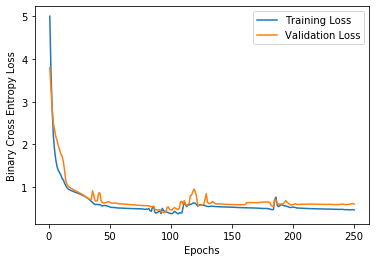

In [8]:
x = np.arange(1,EPOCHS+1,1)
yt = df['loss'].values
yv = df['val_loss'].values
plt.plot(x,yt,label='Training Loss')
plt.plot(x,yv,label='Validation Loss')
plt.legend()
#plt.ylim(0.2,0.8)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.savefig('TrainingLogLSTM.png')
plt.show()

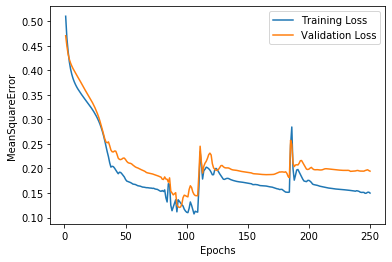

In [9]:
x = np.arange(1,EPOCHS+1,1)
yt = df['mse'].values
yv = df['val_mse'].values
plt.plot(x,yt,label='Training Loss')
plt.plot(x,yv,label='Validation Loss')
plt.legend()
#plt.ylim(0.2,0.8)
plt.xlabel('Epochs')
plt.ylabel('MeanSquareError')
plt.savefig('TrainingLogMSE_LSTM.png')
plt.show()

In [5]:
loadedModel = ks.models.load_model('QuantLSTM.h5')
Y_TEST_PRED = loadedModel.predict(X_TEST).flatten()

In [11]:
def getMetrics(setName,y_true,y_prob,t):
    print('-------------------',setName,'--------------------------')
    X = len(y_true)
    T = sum(y_true)
    F = X-T
    print('Total points : ' + str(X))
    print('Positive points : ' + str(T))
    print('Negative points : ' + str(F))

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    precision, recall, thresholdsPR = precision_recall_curve(y_true, y_prob)
    aucPR = auc(recall, precision)

    print('AUC ROC:', auc_roc)
    print('AUC PR: ', aucPR)
    plt.plot(fpr,tpr)
    plt.title('ROC')
    plt.show()
    plt.plot(recall,precision)
    plt.title('Precision Recall')
    plt.show()
    

    dist_corner = (1-tpr)*(1-tpr) + fpr*fpr
    ind = np.argmin(dist_corner)
    print('Best threshold according to corner rule and its index: ',thresholds[ind],"   ",ind)
    sens = tpr[ind]
    spec = 1 - fpr[ind]
    print('Sensitivity: ', sens)
    print('Specificity : ', spec)

    print('ON  A PARTICULAR THRESHOLD')
    print('This threshold being ', t)
    dist = abs(t-thresholds)
    ind = list(dist).index(min(list(dist)))
    print('Best threshold based on point closest to t: ' + str(thresholds[ind]))
    sens = tpr[ind]
    spec = 1-fpr[ind]
    acc = (sens*T + spec*F)/X
    print('Sensitivity at threshold : ' + str(sens))
    print('Specificiy at threshold : ' + str(spec))
    print('Accuracy at threshold : ' + str(acc))

------------------- LSTM Classification Metrics on Test Set --------------------------
Total points : 510
Positive points : 252.0
Negative points : 258.0
AUC ROC: 0.8937030884705304
AUC PR:  0.9142938471426287


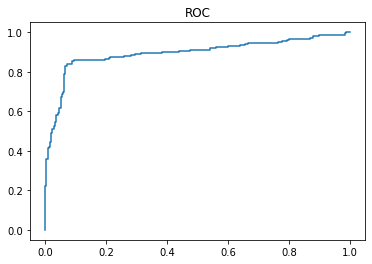

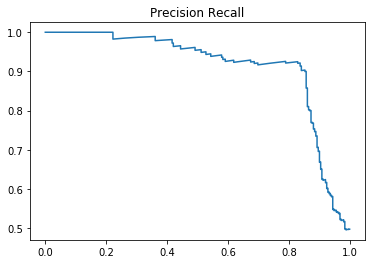

Best threshold according to corner rule and its index:  0.29113963     44
Sensitivity:  0.8571428571428571
Specificity :  0.9069767441860466
ON  A PARTICULAR THRESHOLD
This threshold being  0.5
Best threshold based on point closest to t: 0.42625287
Sensitivity at threshold : 0.8293650793650794
Specificiy at threshold : 0.9302325581395349
Accuracy at threshold : 0.8803921568627451


In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
getMetrics('LSTM Classification Metrics on Test Set',Y_TEST,Y_TEST_PRED,0.5)

In [6]:
def getMetrics2(setName,y_true,y_prob,t):
    print('-------------------',setName,'--------------------------')
    X = len(y_true)
    T = sum(y_true)
    F = X-T
    print('Total points : ' + str(X))
    print('Positive points : ' + str(T))
    print('Negative points : ' + str(F))

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    precision, recall, thresholdsPR = precision_recall_curve(y_true, y_prob)
    aucPR = auc(recall, precision)

    print('AUC ROC:', auc_roc)
    print('AUC PR: ', aucPR)
    plt.plot(fpr,tpr)
    plt.title('ROC')
    plt.show()
    plt.plot(recall,precision)
    plt.title('Precision Recall')
    plt.show()
    
    ind = np.argmax(tpr - fpr)
    print('Best threshold according to corner rule and its index: ',thresholds[ind],"   ",ind)
    sens = tpr[ind]
    spec = 1 - fpr[ind]
    print('Sensitivity: ', sens)
    print('Specificity : ', spec)

    print('ON  A PARTICULAR THRESHOLD')
    print('This threshold being ', t)
    dist = abs(t-thresholds)
    ind = list(dist).index(min(list(dist)))
    print('Best threshold based on point closest to t: ' + str(thresholds[ind]))
    sens = tpr[ind]
    spec = 1-fpr[ind]
    acc = (sens*T + spec*F)/X
    print('Sensitivity at threshold : ' + str(sens))
    print('Specificiy at threshold : ' + str(spec))
    print('Accuracy at threshold : ' + str(acc))

------------------- LSTM Classification Metrics on Test Set --------------------------
Total points : 510
Positive points : 252.0
Negative points : 258.0
AUC ROC: 0.8937030884705304
AUC PR:  0.9142938471426287


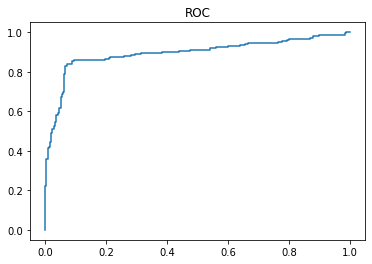

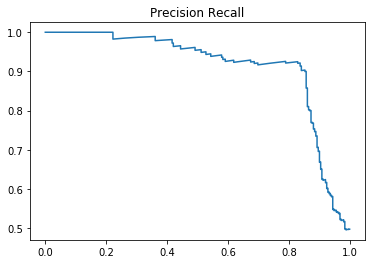

Best threshold according to corner rule and its index:  0.36829844     38
Sensitivity:  0.8373015873015873
Specificity :  0.9302325581395349
ON  A PARTICULAR THRESHOLD
This threshold being  0.5
Best threshold based on point closest to t: 0.42625287
Sensitivity at threshold : 0.8293650793650794
Specificiy at threshold : 0.9302325581395349
Accuracy at threshold : 0.8803921568627451


In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
getMetrics2('LSTM Classification Metrics on Test Set',Y_TEST,Y_TEST_PRED,0.5)